## Solving:

## Mesoscopic constriction in a constant magnetic field

## Import libraries

In [1]:
import kwant
import numpy as np
import scipy.sparse.linalg as lin

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os.path
def save_image(name):
    folder = "./figures/"
    if os.path.exists(folder + name + ".png"):
        raise Exception("File already exist")
        return 0
    
    plt.savefig(folder + name + ".png", dpi=300)

## Create an “empty” tight binding system

In [2]:
t = 1
w_l = 20
w_s = 10
l_s = 10
l_l = 20
a = 1

#define square lattice
lat = kwant.lattice.square(a)

#build system
syst = kwant.Builder()

## Set its matrix elements and hoppings

In [3]:
for i in range(2*l_l+l_s):
    for j in range(w_l):
        # On-site Hamiltonian
        syst[lat(i, j)] = 4 * t
        # Hopping in y-direction
        if j > 0:
            syst[lat(i, j), lat(i, j - 1)] = -t
        # Hopping in x-direction
        if i > 0:
            syst[lat(i, j), lat(i - 1, j)] = -t

syst[(lat(x, y) for x in range(2*l_l+l_s) for y in range(w_l))] = 4 * t
syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t
syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t

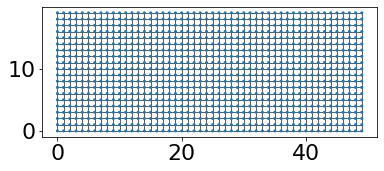

In [4]:
_ = kwant.plot(syst)

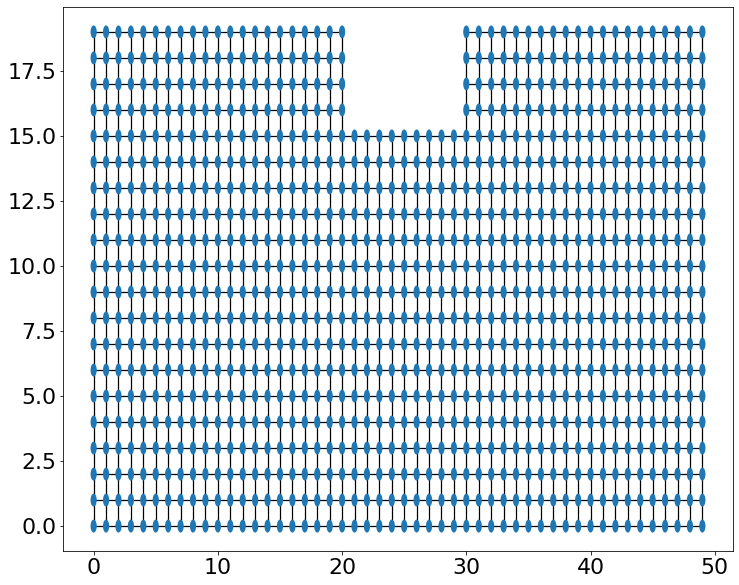

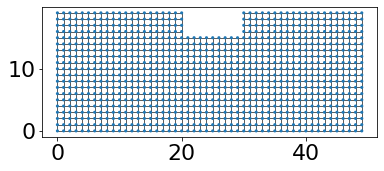

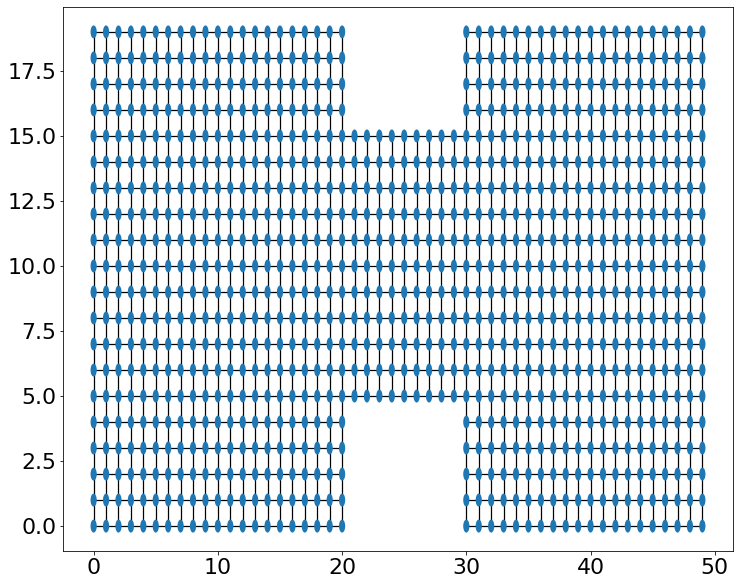

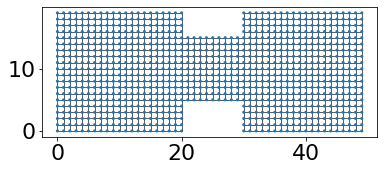

In [5]:
syst = kwant.Builder()
syst[(lat(x, y) for x in range(2*l_l+l_s) for y in range(w_l))] = 4 * t
syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t
syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t

def up_hole(site):
    x1, y1 = site.pos / a - ((2*l_l+l_s)/2, w_l)
    x2, y2 = site.pos / a - ((2*l_l+l_s)/2, 0)

    return (abs(x1) < l_s/2 and abs(y1) < (w_l - w_s)/2)

def down_hole(site):
    x1, y1 = site.pos / a - ((2*l_l+l_s)/2, w_l)
    x2, y2 = site.pos / a - ((2*l_l+l_s)/2, 0)

    return (abs(x2) < l_s/2 and abs(y2) < (w_l - w_s)/2)


for site in filter(up_hole, list(syst.sites())):
    del syst[site]

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = kwant.plot(syst, ax=ax)
#save_image("constriction1")
_ = kwant.plot(syst)

for site in filter(down_hole, list(syst.sites())):
    del syst[site]

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = kwant.plot(syst, ax=ax)
#save_image("constriction2")
_ = kwant.plot(syst)

## Attach leads

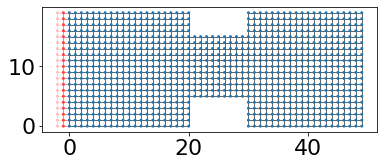

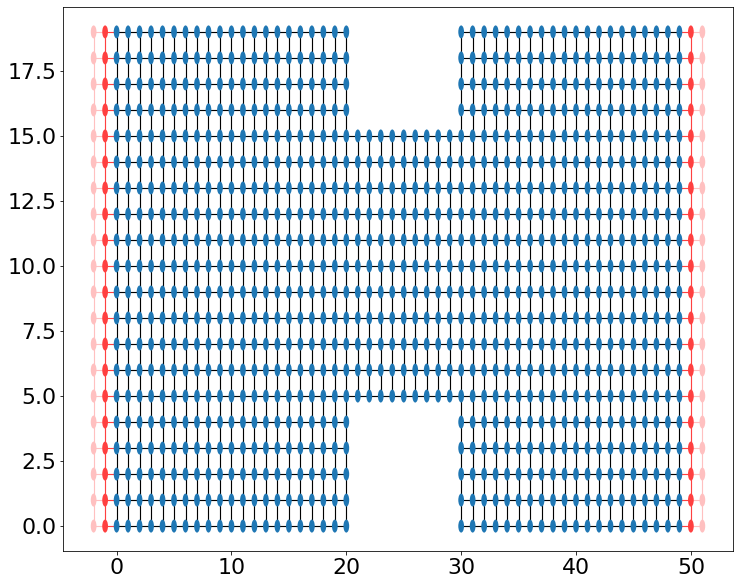

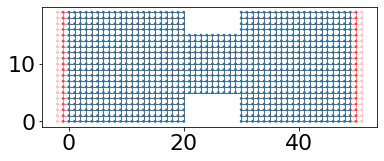

In [6]:
#utilising translational simmetry for building the lead
sym_lead = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(sym_lead)

#region of lead
for j in range(w_l):
    #define on site
    lead[lat(0, j)] = 4 * t
    #define hopping
    if j > 0:
        lead[lat(0, j), lat(0, j - 1)] = -t
    lead[lat(1, j), lat(0, j)] = -t
    
syst.attach_lead(lead)
_ = kwant.plot(syst)
syst.attach_lead(lead.reversed())

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = kwant.plot(syst, ax=ax)
#save_image("constriction_leads")
_ = kwant.plot(syst)

In [7]:
syst = syst.finalized()

## Pass the finalized system to a solver.

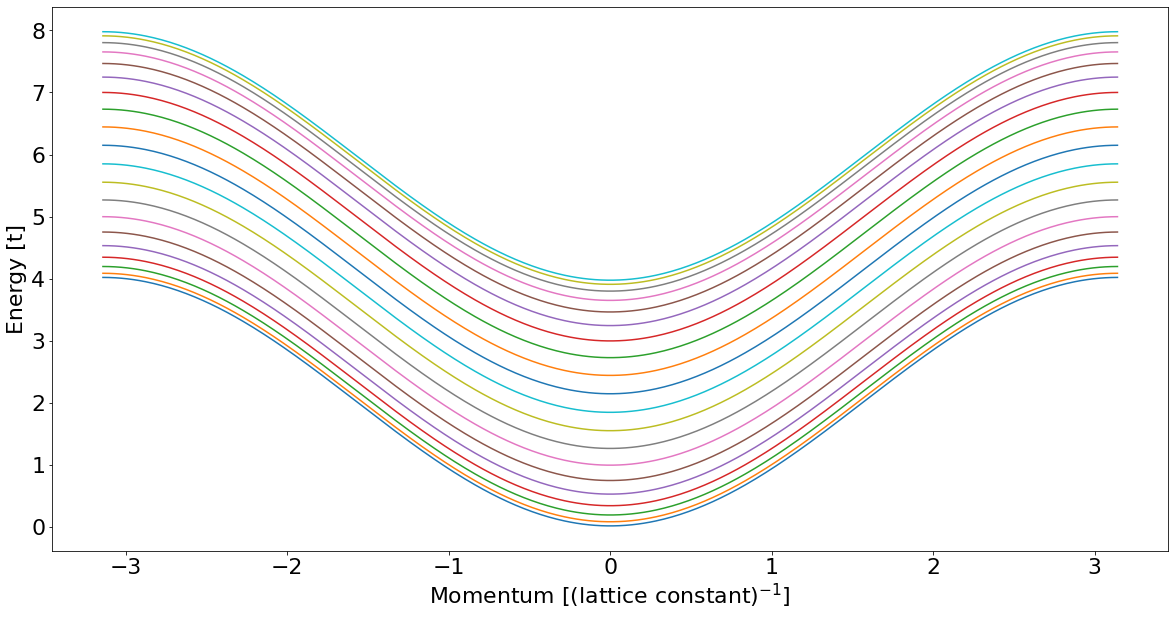

In [8]:
# Compute the band structure of lead 1
momenta = np.linspace(-np.pi, np.pi, 500)

bands = kwant.physics.Bands(syst.leads[0])
energies = [bands(k) for k in momenta]

plt.figure(figsize=(20,10))
plt.plot(momenta, energies)
plt.xlabel(r'Momentum [(lattice constant)$^{-1}$]')
plt.ylabel("Energy [t]")
plt.show()

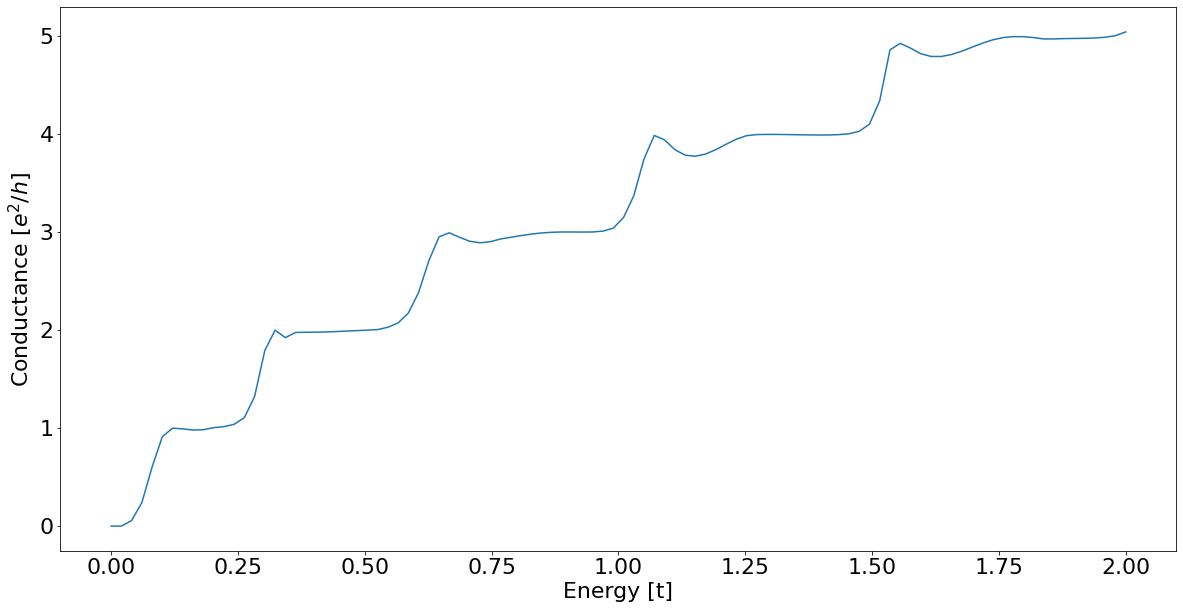

In [11]:
# Plot conductance.
energies = np.linspace(0, 2*t, 100)

# Compute transmission as a function of energy
data = []
for energy in energies:
    smatrix = kwant.smatrix(syst, energy)
    data.append(smatrix.transmission(0, 1))

plt.figure(figsize=(20,10))
plt.plot(energies, data)
plt.xlabel("Energy [t]")
plt.ylabel(r'Conductance $[e^2/h]$')
plt.show()